# **import libaray**

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

# **Introduction**

# **Data Loading**

**Load data from google drive** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv("/content/drive/MyDrive/Datasets/Recommended System/Placement_Data_Full_Class.csv")

In [ ]:
data.head()

sl_no gender  ssc_p    ssc_b  ...  specialisation  mba_p      status    salary
0      1      M  67.00   Others  ...          Mkt&HR  58.80      Placed  270000.0
1      2      M  79.33  Central  ...         Mkt&Fin  66.28      Placed  200000.0
2      3      M  65.00  Central  ...         Mkt&Fin  57.80      Placed  250000.0
3      4      M  56.00  Central  ...          Mkt&HR  59.43  Not Placed       NaN
4      5      M  85.80  Central  ...         Mkt&Fin  55.50      Placed  425000.0

[5 rows x 15 columns]

In [ ]:
data.size

# **Preprocessing**

**Check Missing Value**


In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

In [ ]:
missing_v = [col for col in data.columns if (data[col].isnull().sum()/data.shape[0]) * 100 > 0.001]
print(len(missing_v))
for cols in missing_v:
    del data[cols]

1


In [ ]:
missing_v = data.isnull().sum()
missing_v.plot.bar(figsize=(15,10))
plt.show()

In [ ]:
np.sum(data.isnull().any(axis=1))

**Imbalance problem**

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
data.specialisation.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Results Status in the Imbalanced Dataset')
plt.show()

**Outlier detection**

In [ ]:
# Detecting outliers with IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

sl_no       107.00
ssc_p        15.10
hsc_p        12.10
degree_p     11.00
etest_p      23.50
mba_p         8.31
dtype: float64


In [ ]:
# Removing outliers from the dataset
data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

(206, 14)

**Hot Encoding**

In [ ]:
data.select_dtypes(include=['object']).columns

Index(['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex',
       'specialisation', 'status'],
      dtype='object')

In [ ]:
data['gender'] = data['gender'].fillna(data['gender'].mode()[0])
data['ssc_b'] = data['ssc_b'].fillna(data['ssc_b'].mode()[0])
data['hsc_b'] = data['hsc_b'].fillna(data['hsc_b'].mode()[0])
data['hsc_s'] = data['hsc_s'].fillna(data['hsc_s'].mode()[0])
data['degree_t'] = data['degree_t'].fillna(data['degree_t'].mode()[0])
data['workex'] = data['workex'].fillna(data['workex'].mode()[0])
data['specialisation'] = data['specialisation'].fillna(data['specialisation'].mode()[0])
data['status'] = data['status'].fillna(data['status'].mode()[0])




In [ ]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in data.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    data[col] = lencoders[col].fit_transform(data[col])

In [ ]:
data

**Feature Scaling**

In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(data)
data = pd.DataFrame(r_scaler.transform(data), index=data.index, columns=data.columns)

In [ ]:
data

**Data spliting**


In [ ]:
X=data.drop('specialisation',axis=1)


In [ ]:
y=data[['specialisation']]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)


# **Feature Selection**


In [ ]:
!pip install boruta


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [ ]:
forest = RandomForestRegressor(n_jobs=-1,max_depth=5)


In [ ]:
boruta= BorutaPy(estimator= forest, n_estimators='auto',max_iter=100)
boruta.fit(np.array(X),np.array(y) )

In [ ]:
green_area= X.columns[boruta.support_].to_list()
blue_area= X.columns[boruta.support_weak_].to_list()

In [ ]:
print('Feature in green ara:',green_area)
print('Feature in blue ara:',blue_area)

In [ ]:
#Calculating Features Importance
def Calculating_Entropy(Labels):
    Calculating_Entropy=0
    labelCounts = Counter(Labels)
    for label in labelCounts:
        probability_of_label = labelCounts[label] / len(Labels)
        Calculating_Entropy -= probability_of_label * math.log2(probability_of_label)
    return Calculating_Entropy

In [ ]:
def Calculating_Information_Gain(str_labels, split_labels):
    Calculating_Information_Gain = Calculating_Entropy(str_labels)
    for branch_subset in split_labels:
        Calculating_Information_Gain -= len(branch_subset) * Calculating_Entropy(branch_subset) / len(str_labels)
    return Calculating_Information_Gain

In [ ]:
def data_split_for_label(dataset, column):
    data_split = []
    col_vals = data[column].unique() 
    for col_val in col_vals:
        data_split.append(dataset[dataset[column] == col_val])
    return(data_split)

In [ ]:
from collections import Counter
import math
IN_gain=[]
Feature_Names=[]
def Results_of_Information_Gain(dataset):
    b_gain = 0
    b_feature = 0
    features = list(data.columns)
    features.remove('specialisation')
    for feature in features:
        data_split = data_split_for_label(data, feature)
        labels_split = [dataframe['specialisation'] for dataframe in data_split]
        gain = Calculating_Information_Gain(dataset['specialisation'], labels_split)
        print(' \n')
        print('-------------------------------------------------------------------------------------------------')
        print('-------------------------------------------------------------------------------------------------')
        print(feature)
        print(gain)
        IN_gain.append(gain)
        Feature_Names.append(feature)
        print('-------------------------------------------------------------------------------------------------')
        print('-------------------------------------------------------------------------------------------------')
        if gain > b_gain:
            b_gain, b_feature = gain, feature
    return b_feature, b_gain

new_data = data_split_for_label(data, Results_of_Information_Gain(data)[0])

 

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
sl_no
0.9902246902198684
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
 

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
gender
0.008109850083307224
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
 

-------------------------------------------------------------------------------------------------
--------------------------------------------------------

In [ ]:
IG=pd.DataFrame()
IG['Features Importance']=IN_gain
IG['Features Importance']=round(IG['Features Importance'],2)
IG['Feature']=Feature_Names
IG=IG.sort_values(by=['Features Importance'], ascending=False)

In [ ]:
Features_Group = IG[IG['Features Importance'] > 0.1] 

In [ ]:
print('Length of group features', len(Features_Group))

Length of group features 6


In [ ]:
print('Selected Features in group:\n\n', Features_Group['Feature'])

Selected Features in group:

 0        sl_no
11       mba_p
4        hsc_p
10     etest_p
2        ssc_p
7     degree_p
Name: Feature, dtype: object


In [ ]:
Group_Features_Data=data[list(Features_Group['Feature'])]

In [ ]:
Group_Features_Data

sl_no     mba_p     hsc_p   etest_p     ssc_p  degree_p
0    0.000000  0.284483  0.889621  0.104167  0.538240  0.195122
1    0.004673  0.564843  0.680890  0.760417  0.792414  0.670244
2    0.009346  0.247001  0.510708  0.520833  0.497011  0.341463
3    0.014019  0.308096  0.247117  0.333333  0.311482  0.048780
4    0.018692  0.160795  0.602965  0.975000  0.925788  0.568293
..        ...       ...       ...       ...       ...       ...
210  0.981308  0.872564  0.741351  0.854167  0.818594  0.673171
211  0.985981  0.090330  0.378913  0.500000  0.352711  0.536585
212  0.990654  0.693778  0.494234  0.187500  0.538240  0.560976
213  0.995327  0.338081  0.477759  0.416667  0.682540  0.195122
214  1.000000  0.337706  0.345964  0.812500  0.435168  0.073171

[215 rows x 6 columns]

#**Data Exploring**

In [ ]:
data.hist(figsize=(50,50),bins = 20, color="#107009AA")
plt.title("Features Distribution")
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Data visualization
import seaborn as sb 
from itertools import product
%matplotlib inline

In [ ]:
# Value of count of different Specialization
data['hsc_s'].value_counts()

Commerce    113
Science      91
Arts         11
Name: hsc_s, dtype: int64

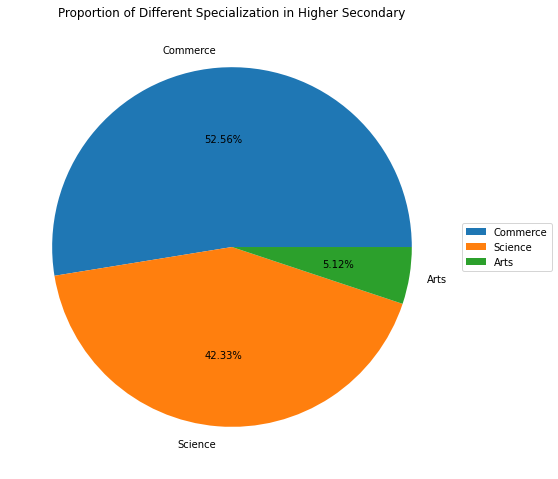

In [ ]:
# Visualization of higher secondary specialization
cls_name = ['Commerce', 'Science', 'Arts']
fig, ax = plt.subplots(figsize = (14.7, 8.27))
wedges, text, autotext = ax.pie(data['hsc_s'].value_counts(), labels = cls_name, autopct = '%1.2f%%')
ax.legend(wedges, cls_name, loc = "center left", bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title("Proportion of Different Specialization in Higher Secondary");

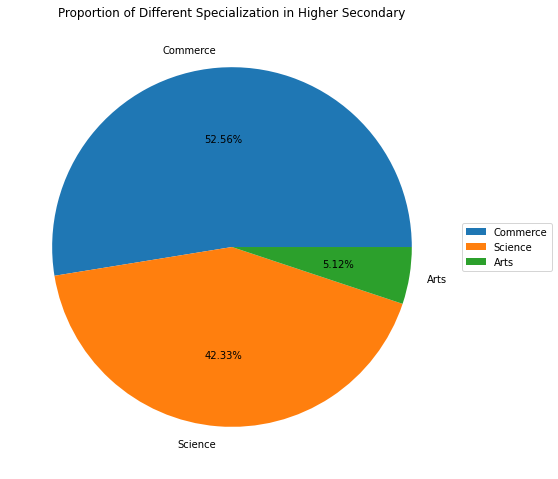

In [ ]:
# Visualization of higher secondary specialization
cls_name = ['Commerce', 'Science', 'Arts']
fig, ax = plt.subplots(figsize = (14.7, 8.27))
wedges, text, autotext = ax.pie(data['hsc_s'].value_counts(), labels = cls_name, autopct = '%1.2f%%')
ax.legend(wedges, cls_name, loc = "center left", bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title("Proportion of Different Specialization in Higher Secondary");

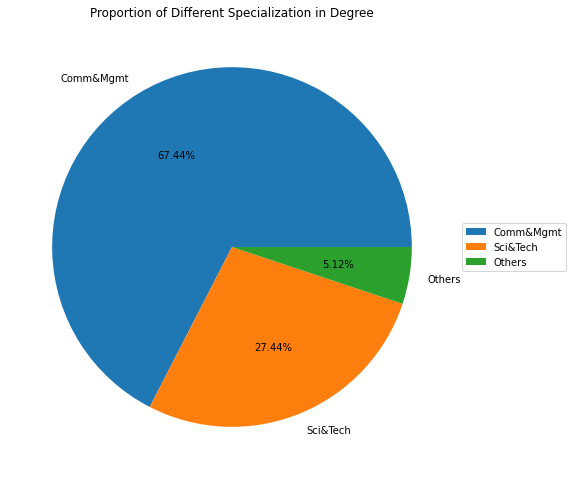

In [ ]:
# Visualization of Degree Specialization
fig, ax = plt.subplots(figsize = (14.7, 8.27))
wedges, text, autotext = ax.pie(data['degree_t'].value_counts(),
                                labels = data['degree_t'].value_counts().index, 
                                autopct = '%1.2f%%')
ax.legend(wedges, data['degree_t'].value_counts().index,
          loc = "center left", bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title("Proportion of Different Specialization in Degree");

Text(0.5, 1.0, 'Proportion of Different Specialization in Post Graduation')

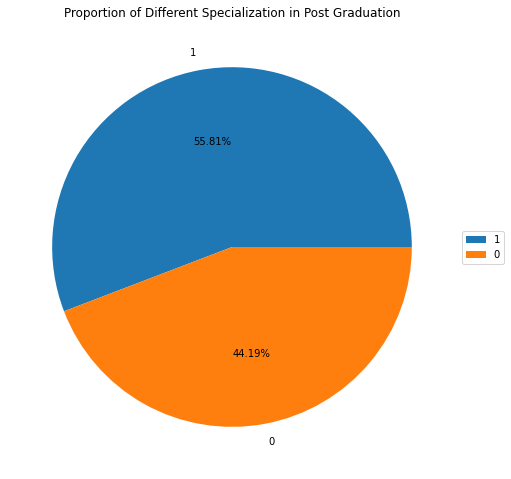

In [ ]:
# Visualization of Postgrad Specialization
fig, ax = plt.subplots(figsize = (14.7, 8.27))
wedges, text, autotext = ax.pie(data['specialisation'].value_counts(),
                                labels = data['specialisation'].value_counts().index, 
                                autopct = '%1.2f%%')
ax.legend(wedges, data['specialisation'].value_counts().index,
          loc = "center left", bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title("Proportion of Different Specialization in Post Graduation")

In [ ]:
!pip install dtale

In [ ]:
import dtale
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Datasets/Recommended System/Placement_Data_Full_Class.csv")
d = dtale.show(df, ignore_duplicate=True)
d

http://c13ddc6c8837:40000/dtale/main/2

**Pandas Profiling**

In [ ]:
!pip install pandas-profiling

In [ ]:
import pandas as pd
import pandas_profiling
import numpy as np

In [ ]:
pandas_profiling.ProfileReport(data)

**Sweetviz**

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz
import pandas as pd
my_report  = sweetviz.analyze([data,'Train'], target_feat='specialisation')
my_report.show_html('FinalReport.html')

                                             |          | [  0%]   00:00 -> (? left)

Report FinalReport.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Autoviz**

It stands for Automatically Visualize. Visualization is possible with any size of the dataset with a few lines of code.

In [ ]:
!pip install autoviz

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
df = AV.AutoViz('/content/drive/MyDrive/Datasets/Recommended System/Placement_Data_Full_Class.csv')

#**Implementaion using pycaret**

In [ ]:
!pip install pycaret


In [ ]:
from pycaret.classification import *
clf = setup(data, target = "specialisation",
            ignore_features=["sl_no"], 
            silent = True, session_id = 786)

In [ ]:
compare_models()


Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.6200  0.6489  0.5429  0.5856   
nb                            Naive Bayes    0.6133  0.6423  0.6476  0.5537   
ridge                    Ridge Classifier    0.6000  0.0000  0.5452  0.5531   
lda          Linear Discriminant Analysis    0.6000  0.6436  0.5452  0.5531   
lightgbm  Light Gradient Boosting Machine    0.5867  0.5788  0.5143  0.5425   
rf               Random Forest Classifier    0.5800  0.5735  0.4238  0.5393   
lr                    Logistic Regression    0.5467  0.5000  0.0000  0.0000   
dt               Decision Tree Classifier    0.5400  0.5281  0.4381  0.5019   
gbc          Gradient Boosting Classifier    0.5333  0.5268  0.4643  0.4662   
knn                K Neighbors Classifier    0.5200  0.5056  0.5405  0.4775   
qda       Quadratic Discriminant Analysis    0.5200  0.5158  0.4857  0.4467   
ada                  Ada Boost Classifier    0.5200  0.5397  0.4857  0.4879   
svm                   SVM - Linear Kernel    0.4867  0.0000  0.5000  0.2200   

              F1   Kappa     MCC  TT (Sec)  
et        0.5498  0.2251  0.2344     0.474  
nb        0.5860  0.2251  0.2431     0.017  
ridge     0.5395  0.1877  0.1905     0.020  
lda       0.5395  0.1877  0.1905     0.018  
lightgbm  0.5217  0.1607  0.1627     0.083  
rf        0.4637  0.1334  0.1378     0.496  
lr        0.0000  0.0000  0.0000     0.333  
dt        0.4568  0.0581  0.0610     0.019  
gbc       0.4556  0.0440  0.0514     0.092  
knn       0.5004  0.0432  0.0410     0.121  
qda       0.4030  0.0282  0.0278     0.020  
ada       0.4798  0.0331  0.0317     0.112  
svm       0.3052  0.0000  0.0000     0.020

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=786, verbose=0,
                     warm_start=False)

In [ ]:
X=data.drop('specialisation',axis=1)


In [ ]:
X

In [ ]:
Y=y=data[['specialisation']]


In [ ]:
Y

# **Statisticlal Operation on Dataset**

In [ ]:
# generate related variables
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
# seed random number generator
seed(1)
# prepare data
data1=X
data2=y
# summarize
print('data1: mean=%.3f stdv=%.3f' % (mean(data1), std(data1)))
print('data2: mean=%.3f stdv=%.3f' % (mean(data2), std(data2)))
# plot
pyplot.scatter(data1, data2)
pyplot.show()

In [ ]:
data.size

3225

In [ ]:

# calculate the covariance between two variables
from numpy.random import randn
from numpy.random import seed
from numpy import cov
# seed random number generator
seed(1)
# calculate covariance matrix
covariance = cov(data1, data2)
print(covariance)

#  **Model Training**

**Decision Trees**

In [ ]:
DTC=DecisionTreeClassifier(random_state=0, max_depth=2)
DTC= DTC.fit(X_train , y_train)
DTC

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
y_pred1 = DTC.predict(X_test)
dt=DTC.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(DTC.score(X_test, y_test)))

Accuracy score= 0.5538




confusion matrix


[[10 25]
 [ 4 26]]




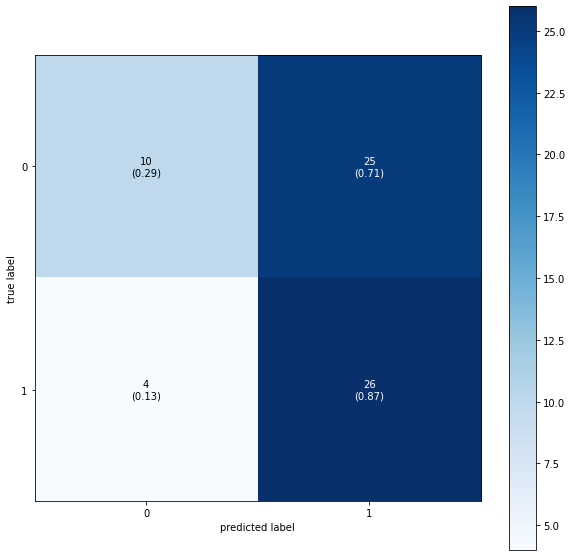

In [ ]:
# confusion matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
#Precision, Recall, F1
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

         0.0       0.71      0.29      0.41        35
         1.0       0.51      0.87      0.64        30

    accuracy                           0.55        65
   macro avg       0.61      0.58      0.53        65
weighted avg       0.62      0.55      0.52        65





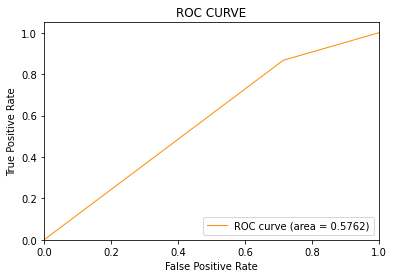

In [ ]:
#ROC CURVE
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Random Forest**

In [ ]:
Ran_For= RandomForestClassifier(n_estimators=100,max_depth=15, random_state=11,max_leaf_nodes=10)
Ran_For= Ran_For.fit(X_train , y_train)
Ran_For

In [ ]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=10, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=10, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [ ]:
y_pred1 = Ran_For.predict(X_test)
rn=Ran_For.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(Ran_For.score(X_test, y_test)))

Accuracy score= 0.6923


In [ ]:
#Confusion Matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
#Precision, Recall, F1

print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        35
         1.0       0.67      0.67      0.67        30

    accuracy                           0.69        65
   macro avg       0.69      0.69      0.69        65
weighted avg       0.69      0.69      0.69        65





In [ ]:
#ROC CURVE
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**ExtraTreesClassifier**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
Extra_TC= clf.fit(X_train , y_train)
Extra_TC

In [ ]:
y_pred_EXTC = Extra_TC.predict(X_test)
rn=Extra_TC.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(Extra_TC.score(X_test, y_test)))

Accuracy score= 0.6769


In [ ]:
#Confusion Matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred_EXTC)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
#Precision, Recall, F1

print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred_EXTC)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71        35
         1.0       0.67      0.60      0.63        30

    accuracy                           0.68        65
   macro avg       0.68      0.67      0.67        65
weighted avg       0.68      0.68      0.68        65





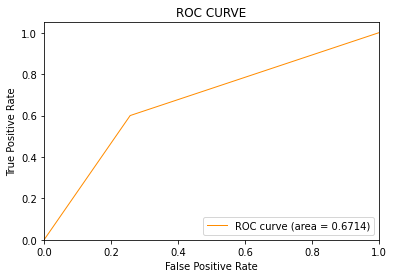

In [ ]:
#ROC CURVE
fpr_EXTC, tpr_EXTC, thresholds = roc_curve(y_test, y_pred_EXTC)
roc_auc = auc(fpr_e, tpr2)
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Gaussian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
GNB=model.fit(X_train , y_train)
GNB

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred_GNB = GNB.predict(X_test)
rn=GNB.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(Extra_TC.score(X_test, y_test)))

Accuracy score= 0.6769


In [ ]:
#Confusion Matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred_GNB)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
#Precision, Recall, F1

print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred_GNB)
print(CR)
print('\n')

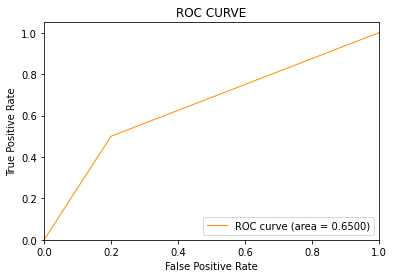

In [ ]:
#ROC CURVE
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_GNB)
roc_auc = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**XGBoost**

In [ ]:

from xgboost import XGBClassifier
model_XGBC = XGBClassifier()
GBC=model_XGBC.fit(X_train , y_train)
model_XGBC


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred_XGBC = model_XGBC.predict(X_test)
rn=GBC.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(model_XGBC.score(X_test, y_test)))

Accuracy score= 0.5846


In [ ]:
#Confusion Matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred_XGBC)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
#Precision, Recall, F1

print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred_XGBC)
print(CR)
print('\n')

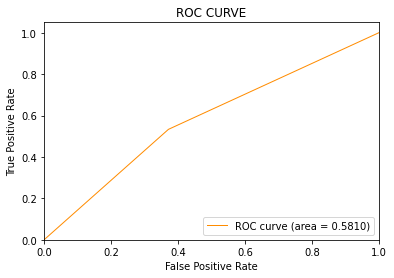

In [69]:
#ROC CURVE
fpr_XGB, tpr_XGB, thresholds = roc_curve(y_test, y_pred_XGBC)
roc_auc = auc(fpr_XGB, tpr_XGB)
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# **Compare Modle performance**


**ROC Curve for Models**

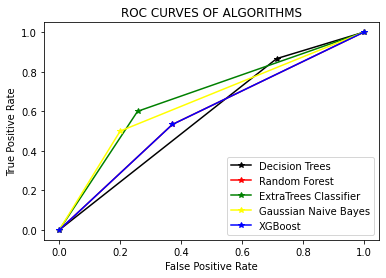

In [70]:
plt.plot(fpr1, tpr1, marker='*', label='Decision Trees', color = 'black')
plt.plot(fpr2, tpr2, marker='*', label='Random Forest', color = 'Red')
plt.plot(fpr_EXTC, tpr_EXTC, marker='*', label='ExtraTrees Classifier', color = 'green')
plt.plot(fpr_GNB, tpr_GNB, marker='*', label='Gaussian Naive Bayes', color = 'yellow')
plt.plot(fpr_XGB, tpr_XGB, marker='*', label='XGBoost', color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVES OF ALGORITHMS')
plt.legend(loc="lower right")
plt.show()

**References**

[Top Python Libraries to Automate Exploratory Data Analysis in 2021](https://www.analyticsvidhya.com/blog/2021/04/top-python-libraries-to-automate-exploratory-data-analysis-in-2021/)